In [1]:
# @title Default title text
# Download images and annotations
!curl http://images.cocodataset.org/zips/val2017.zip --output coco_valid.zip
!curl http://images.cocodataset.org/annotations/annotations_trainval2017.zip --output coco_valid_anns.zip
# Unzip images into coco_val2017/images
!mkdir coco_val2017/
!unzip -q coco_valid.zip -d coco_val2017/
!mv -f coco_val2017/val2017 coco_val2017/images
# Unzip and keep only valid annotations as coco_val2017/annotations.json
!unzip -q coco_valid_anns.zip -d coco_val2017
!mv -f coco_val2017/annotations/instances_val2017.json coco_val2017/annotations.json
!rm -rf coco_val2017/annotations
# Remove zip files downloaded
!rm -f coco_valid.zip
!rm -f coco_valid_anns.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  777M  100  777M    0     0  84.7M      0  0:00:09  0:00:09 --:--:-- 76.6M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  241M  100  241M    0     0  86.2M      0  0:00:02  0:00:02 --:--:-- 86.2M


In [8]:
# @title Default title text
# Copyright © 2022 Bernat Puig Camps
import json
from pathlib import Path
from typing import Tuple

import pandas as pd

DATA_PATH = Path("./coco_val2017/images")


def load_dataset(
    data_path: Path = DATA_PATH,
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Read the COCO style json dataset and transform it into convenient DataFrames
    :return (images_df, targets_df):
        images_df: Columns "image_id" and "file_name"
        targets_df: Columns
            "target_id", "image_id", "xmin", "ymin", "xmax", "ymax", "label_id"
    """
    annotations_path = data_path / "annotations.json"

    with open(annotations_path, "r") as f:
        targets_json = json.load(f)

    images_df = pd.DataFrame.from_records(targets_json["images"])
    images_df.rename(columns={"id": "image_id"}, inplace=True)
    images_df = images_df[["image_id", "file_name"]]

    targets_df = pd.DataFrame.from_records(targets_json["annotations"])
    targets_df[["xmin", "ymin", "w", "h"]] = targets_df["bbox"].tolist()
    targets_df["xmax"] = targets_df["xmin"] + targets_df["w"]
    targets_df["ymax"] = targets_df["ymin"] + targets_df["h"]
    targets_df.reset_index(inplace=True)
    targets_df.rename(
        columns={"index": "target_id", "category_id": "label_id"}, inplace=True
    )
    targets_df = targets_df[
        ["target_id", "image_id", "label_id", "xmin", "ymin", "xmax", "ymax"]
    ]

    return images_df, targets_df

In [3]:
# @title Default title text
images_df, targets_df = load_dataset()


In [14]:
# @title Hope The Loss is Correct
from pathlib import Path

import pandas as pd
from PIL import Image
import torch
import torchvision


def get_predictions(
    images_path: Path, images_df: pd.DataFrame, targets_df: pd.DataFrame
):
    model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

    device = (
        torch.device("cuda:0")
        if torch.cuda.is_available()
        else torch.device("cpu")
    )
    print(device)
    model = model.to(device)

    preds_dfs = []
    for sample in images_df.itertuples():
        # We iterate over single samples (batch size of 1) because we need one
        # loss per image and PyTorch Faster-RCNN outputs losses per batch,
        # not sample.
        t_df = targets_df.query("image_id == @sample.image_id")

        image = Image.open(images_path / sample.file_name).convert("RGB")
        image = image.to(device, non_blocking=True).float() / 255  # uint8 to float32, 0-255 to 0.0-1.0
        image_tensor = torchvision.transforms.ToTensor()(image).to(device)

        bboxes = t_df[["xmin", "ymin", "xmax", "ymax"]].values
        labels = t_df["label_id"].values
        if bboxes.size == 0:
            # PyTorch Faster-RCNN expects targets to be tensors that fulfill
            # len(boxes.shape) == 2 & boxes.shape[-1] == 4
            bboxes = torch.empty(0, 4)

        targets = {
            "boxes": torch.as_tensor(bboxes, dtype=torch.float32).to(device),
            "labels": torch.as_tensor(labels, dtype=torch.int64).to(device),
        }
        with torch.no_grad():
            # Faster-RCNN outputs losses only when train mode Hope its same with Yolov5
            model.train()
            pred = model(image)  # forward
            losses = model([image_tensor], [targets])
            # Faster-RCNN outputs predictions only when eval mode
            model.eval()
            preds = model([image_tensor])
        # Unify all sublosses into one (this is just one way of doing it)
        loss = sum(losses.values()).item()

        preds_dfs.append(
            pd.DataFrame(
                {
                    "image_id": sample.image_id,
                    "image_loss": loss,
                    "label_id": preds[0]["labels"].to("cpu"),
                    "score": preds[0]["scores"].to("cpu"),
                    "xmin": preds[0]["boxes"][:, 0].to("cpu"),
                    "ymin": preds[0]["boxes"][:, 1].to("cpu"),
                    "xmax": preds[0]["boxes"][:, 2].to("cpu"),
                    "ymax": preds[0]["boxes"][:, 3].to("cpu"),
                }
            )
        )

    preds_df = pd.concat(preds_dfs, ignore_index=True)
    preds_df = preds_df.reset_index().rename(columns={"index": "pred_id"})
    return preds_df[
        [
            "pred_id",
            "image_id",
            "label_id",
            "xmin",
            "ymin",
            "xmax",
            "ymax",
            "score",
            "image_loss",
        ]
    ]

In [ ]:
! git clone https://github.com/ultralytics/yolov5
! cd yolov5
! pip install -r yolov5/requirements.txt

In [45]:
import torch

# Model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

# Images
imgs = ['https://ultralytics.com/images/zidane.jpg']  # batch of images

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-2-3 Python-3.10.12 torch-2.1.0+cu121 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


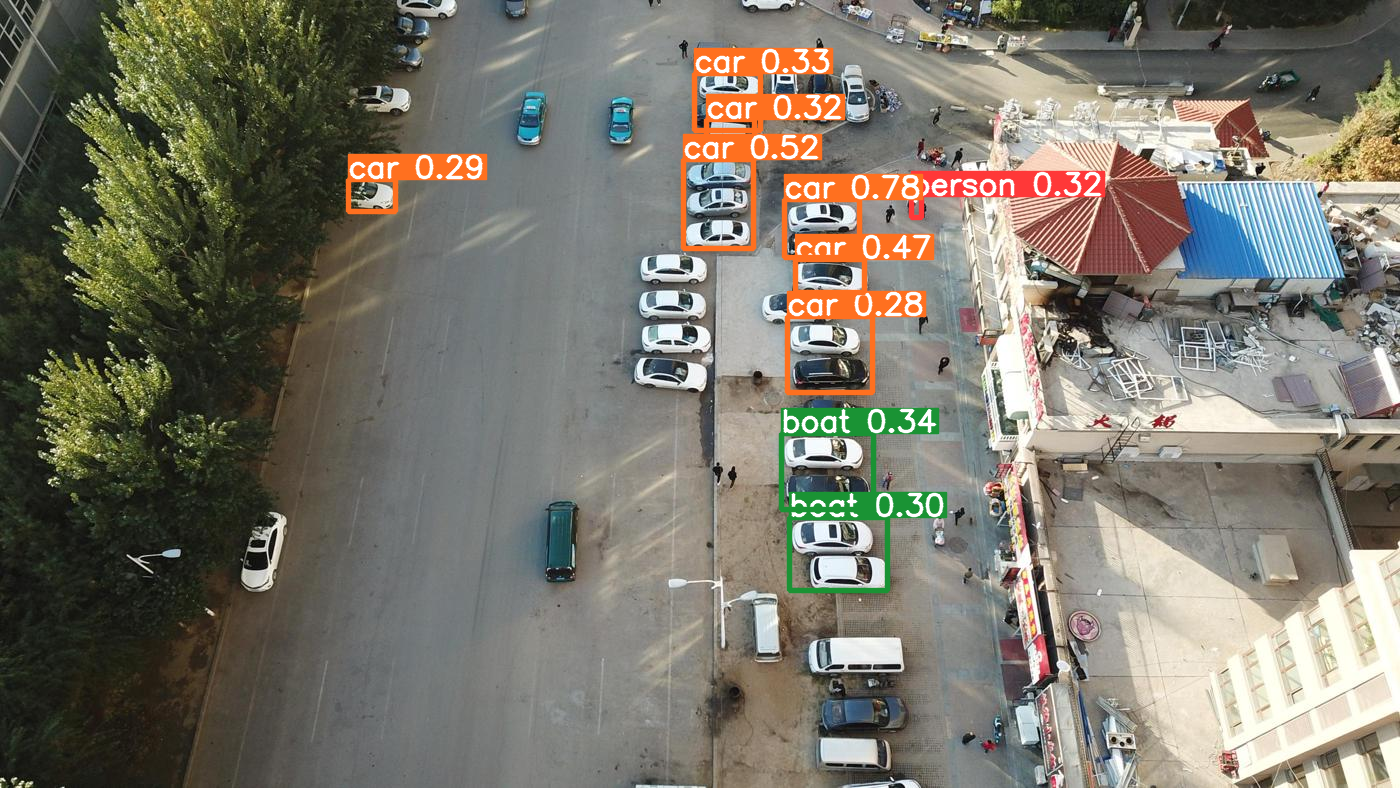

In [47]:
# Inference //This will give me the results. I need to get the loss
model.eval()
results = model("../datasets/VisDrone/VisDrone2019-DET-train/images/9999965_00000_d_0000035.jpg")
results.show()

In [26]:
model.train()
results = model(imgs)
print(results)

image 1/1: 720x1280 (no detections)
Speed: 491.3ms pre-process, 332.1ms inference, 0.9ms NMS per image at shape (1, 3, 384, 640)


In [28]:
model.parameters()


<generator object Module.parameters at 0x7fd764ae1d90>

In [ ]:
# @title Default title text
from ultralytics import YOLO

from utils.loss import ComputeLoss

loss_obj = ComputeLoss(model)


In [ ]:
# @title Yolov5 Works Last Year RUN ONCE

# Default imports and definitions
import os
import glob as glob
import matplotlib.pyplot as plt
import cv2
import requests
import random
import numpy as np
from utils.general import download, os, Path

path= "../datasets/VisDrone"  # dataset root dir
train= "VisDrone2019-DET-train/images"  # train images (relative to 'path')  6471 images
val= "VisDrone2019-DET-val/images"  # val images (relative to 'path')  548 images
test= "VisDrone2019-DET-test-dev/images"  # test images (optional)  1610 images

# Visdrone.yaml içindeki fonksiyon
def visdrone2yolo(dir):
    from PIL import Image
    from tqdm import tqdm

    def convert_box(size, box):
        # Convert VisDrone box to YOLO xywh box
        dw = 1. / size[0]
        dh = 1. / size[1]
        return (box[0] + box[2] / 2) * dw, (box[1] + box[3] / 2) * dh, box[2] * dw, box[3] * dh

    (dir / 'labels').mkdir(parents=True, exist_ok=True)  # make labels directory
    pbar = tqdm((dir / 'annotations').glob('*.txt'), desc=f'Converting {dir}')
    for f in pbar:
        img_size = Image.open((dir / 'images' / f.name).with_suffix('.jpg')).size
        lines = []
        with open(f, 'r') as file:  # read annotation.txt
            for row in [x.split(',') for x in file.read().strip().splitlines()]:
                if row[4] == '0':  # VisDrone 'ignored regions' class 0
                    continue
                cls = int(row[5]) - 1
                box = convert_box(img_size, tuple(map(int, row[:4])))
                lines.append(f"{cls} {' '.join(f'{x:.6f}' for x in box)}\n")
                with open(str(f).replace(os.sep + 'annotations' + os.sep, os.sep + 'labels' + os.sep), 'w') as fl:
                    fl.writelines(lines)  # write label.txt




# This part handles download and converting. Needs to be called only once in the beginning.
dir = Path(path)  # dataset root dir
urls = ['https://github.com/ultralytics/yolov5/releases/download/v1.0/VisDrone2019-DET-train.zip',
          'https://github.com/ultralytics/yolov5/releases/download/v1.0/VisDrone2019-DET-val.zip',
          'https://github.com/ultralytics/yolov5/releases/download/v1.0/VisDrone2019-DET-test-dev.zip',
          'https://github.com/ultralytics/yolov5/releases/download/v1.0/VisDrone2019-DET-test-challenge.zip']
download(urls, dir=dir, curl=True, threads=4)
  # Convert
for d in 'VisDrone2019-DET-train', 'VisDrone2019-DET-val', 'VisDrone2019-DET-test-dev':
    visdrone2yolo(dir / d)  # convert VisDrone annotations to YOLO labels

np.random.seed(42)

# If train is false, use last trained model
TRAIN = True
# Number of epochs to train for.
EPOCHS = 25

#For visualization.
class_names = ['pedestrian', 'people', 'bicycle', 'car', 'van', 'truck', 'tricycle', 'awning-tricycle', 'bus', 'motor']
colors = np.random.uniform(0, 255, size=(len(class_names), 3))


def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax





In [52]:
#@title PLOT PART


def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # denormalize the coordinates
        xmin = int(x1*w)
        ymin = int(y1*h)
        xmax = int(x2*w)
        ymax = int(y2*h)
        width = xmax - xmin
        height = ymax - ymin

        class_name = class_names[int(labels[box_num])]

        cv2.rectangle(
            image,
            (xmin, ymin), (xmax, ymax),
            color=colors[class_names.index(class_name)],
            thickness=2
        )

        font_scale = min(1,max(3,int(w/500)))
        font_thickness = min(2, max(10,int(w/50)))

        p1, p2 = (int(xmin), int(ymin)), (int(xmax), int(ymax))
        # Text width and height
        tw, th = cv2.getTextSize(
            class_name,
            0, fontScale=font_scale, thickness=font_thickness
        )[0]
        p2 = p1[0] + tw, p1[1] + -th - 10
        cv2.rectangle(
            image,
            p1, p2,
            color=colors[class_names.index(class_name)],
            thickness=-1,
        )
        cv2.putText(
            image,
            class_name,
            (xmin+1, ymin-10),
            cv2.FONT_HERSHEY_SIMPLEX,
            font_scale,
            (255, 255, 255),
            font_thickness
        )
    return image


# Function to plot images with the bounding boxes.
def plot(image_paths, label_paths, num_samples):
    print(image_paths)
    all_training_images = glob.glob(image_paths)
    all_training_labels = glob.glob(label_paths)
    all_training_images.sort()
    all_training_labels.sort()

    num_images = len(all_training_images)

    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        j = random.randint(0,num_images-1)
        image = cv2.imread("../datasets/VisDrone/VisDrone2019-DET-train/images/9999965_00000_d_0000035.jpg")
        with open("../datasets/VisDrone/VisDrone2019-DET-train/labels/9999965_00000_d_0000035.txt", 'r') as f:
            print(j)
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label = label_line[0]
                bbox_string = label_line[2:]
                x_c, y_c, w, h = bbox_string.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i+1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')
    plt.subplots_adjust(wspace=0)
    plt.tight_layout()
    plt.savefig("output.jpg") #save as jpg


In [53]:
# Sunum için iyi.
# Visualize a few training images.
plot(
    image_paths='../datasets/VisDrone/VisDrone2019-DET-train/images/*',
    label_paths='../datasets/VisDrone/VisDrone2019-DET-train/labels/*',
    num_samples=1,
)

../datasets/VisDrone/VisDrone2019-DET-train/images/*
../datasets/VisDrone/VisDrone2019-DET-train/images/0000270_03801_d_0000372.jpg
Bura?


In [63]:
!gdown --fuzzy https://drive.google.com/file/d/1-vJvLgR1zeWcMwosD5ob7AukDnGw5WdL/view?usp=drive_link

Downloading...
From (original): https://drive.google.com/uc?id=1-vJvLgR1zeWcMwosD5ob7AukDnGw5WdL
From (redirected): https://drive.google.com/uc?id=1-vJvLgR1zeWcMwosD5ob7AukDnGw5WdL&confirm=t&uuid=79a6ba4f-b415-4656-b9d1-a1ce8702a296
To: /content/best.pt
100% 168M/168M [00:01<00:00, 92.7MB/s]


In [70]:
model = torch.hub.load('yolov5', 'custom', path='best.pt', source='local')


YOLOv5 🚀 2024-2-3 Python-3.10.12 torch-2.1.0+cu121 CPU

Fusing layers... 
Model summary: 212 layers, 20889303 parameters, 0 gradients, 48.0 GFLOPs
Adding AutoShape... 


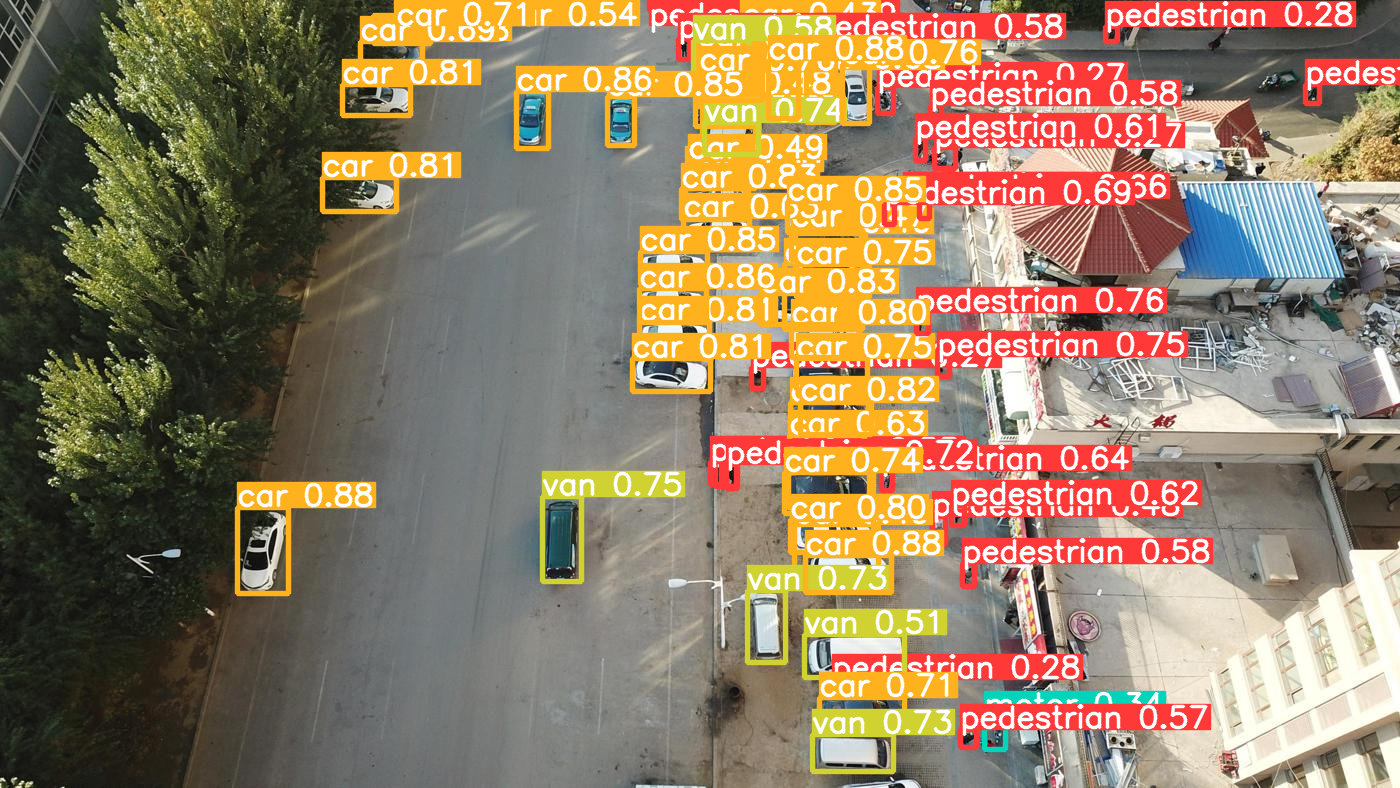

In [71]:
model.eval()
results = model("../datasets/VisDrone/VisDrone2019-DET-train/images/9999965_00000_d_0000035.jpg")
results.show()

In [72]:
results.xyxy[0]

tensor([[8.05874e+02, 5.55095e+02, 8.91148e+02, 5.92457e+02, 8.80711e-01, 3.00000e+00],
        [2.37159e+02, 5.07283e+02, 2.88646e+02, 5.93826e+02, 8.79772e-01, 3.00000e+00],
        [7.68781e+02, 6.08809e+01, 7.98055e+02, 1.18263e+02, 8.77549e-01, 3.00000e+00],
        [5.16776e+02, 9.11310e+01, 5.48210e+02, 1.48181e+02, 8.63586e-01, 3.00000e+00],
        [6.39166e+02, 2.88021e+02, 7.06182e+02, 3.22025e+02, 8.55775e-01, 3.00000e+00],
        [6.07628e+02, 9.64475e+01, 6.34713e+02, 1.45140e+02, 8.52476e-01, 3.00000e+00],
        [6.40347e+02, 2.51765e+02, 7.07535e+02, 2.84916e+02, 8.50125e-01, 3.00000e+00],
        [7.87701e+02, 2.01634e+02, 8.57575e+02, 2.32728e+02, 8.47076e-01, 3.00000e+00],
        [7.60574e+02, 2.93126e+02, 8.39119e+02, 3.24247e+02, 8.33950e-01, 3.00000e+00],
        [6.81174e+02, 1.88225e+02, 7.45137e+02, 2.19587e+02, 8.27601e-01, 3.00000e+00],
        [8.00638e+02, 4.01843e+02, 8.71854e+02, 4.34330e+02, 8.24722e-01, 3.00000e+00],
        [6.32335e+02, 3.58327e+0